In [1]:
import torch
import torchaudio
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

In [2]:
PATH = '/workspace/model/traffic_light_model.pth'

model = models.mobilenet_v2(pretrained=True)
NUM_CLASSES=4
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)

model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

(1, 'green')

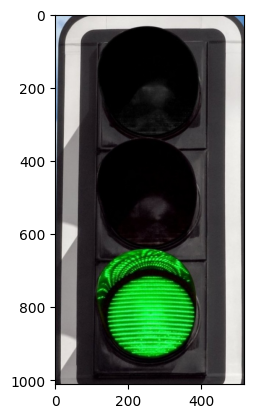

In [3]:
color = ["black", "green", "red", "orange"]

img = cv2.imread("/workspace/test_img/green.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)
input_tensor = transform(img)
input_tensor = input_tensor.to(device)
output = model(input_tensor.reshape(1, *input_tensor.shape))
i = np.argmax(output.cpu().detach().numpy()[0])
i, color[i]

# YoLo

In [4]:
from inference import get_model
import supervision as sv

In [5]:
img = cv2.imread("/workspace/test_img/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)

(1571, 9)
(1546, 11)
(1557, 9)


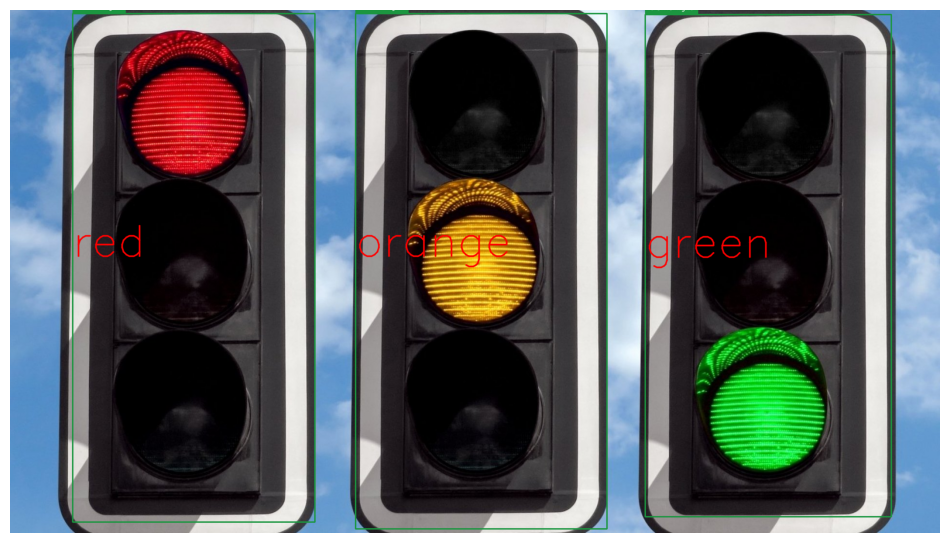

In [6]:
yolo = get_model(model_id="yolov11n-1280")

results = yolo.infer(img)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(scene=img, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = np.asarray(annotated_image)
annotated_image = annotated_image.copy()

for i, d in enumerate(detections.xyxy):
    className = detections.data["class_name"][i]
    if className != "traffic light":
        continue

    cropped = np.array(img)[int(d[1]):int(d[3]), int(d[0]):int(d[2])]

    cropped = Image.fromarray(cropped)
    input_tensor = transform(cropped)
    input_tensor = input_tensor.to(device)
    output = model(input_tensor.reshape(1, *input_tensor.shape))
    j = np.argmax(output.cpu().detach().numpy()[0])

    _color = color[j]

    font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale
    fontScale = 3
    # Blue color in BGR
    fontColor = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2

    print((int(d[3] + 500), int(d[1])))

    annotated_image = cv2.putText(annotated_image, _color, (int(d[0]), int(d[1] + 500)), font, 
                fontScale, fontColor, thickness, cv2.LINE_AA)

# display the image
sv.plot_image(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

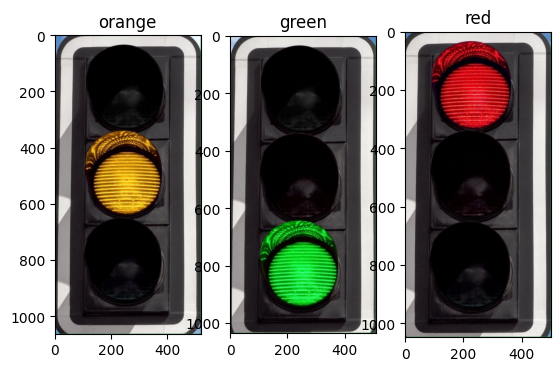

In [7]:
i=1
for d in detections.xyxy:
    plt.subplot(1,3,i)

    cropped = np.array(img)[int(d[1]):int(d[3]), int(d[0]):int(d[2])]
    _cropped = cropped.copy()

    cropped = Image.fromarray(cropped)
    input_tensor = transform(cropped)
    input_tensor = input_tensor.to(device)
    output = model(input_tensor.reshape(1, *input_tensor.shape))
    j = np.argmax(output.cpu().detach().numpy()[0])

    plt.title(color[j])
    plt.imshow(_cropped)
    i+=1

# Test with a video

In [8]:
def pipeline(frame):
    _img = frame.copy()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    results = yolo.infer(img)[0]

    # load the results into the supervision Detections api
    detections = sv.Detections.from_inference(results)

    for i, d in enumerate(detections.xyxy):
        x_min, y_min, x_max, y_max = d
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        label = detections.data["class_name"][i]

        # Draw the bounding box
        cv2.rectangle(_img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Add the label above the bounding box
        text_position = (x_min, y_min - 10)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (0, 255, 0)
        cv2.putText(_img, label, text_position, font, font_scale, text_color, font_thickness)


    for i, d in enumerate(detections.xyxy):
        className = detections.data["class_name"][i]
        if className != "traffic light":
            continue

        cropped = np.array(img)[int(d[1]):int(d[3]), int(d[0]):int(d[2])]

        cropped = Image.fromarray(cropped)
        input_tensor = transform(cropped)
        input_tensor = input_tensor.to(device)
        output = model(input_tensor.reshape(1, *input_tensor.shape))
        j = np.argmax(output.cpu().detach().numpy()[0])

        _color = color[j]

        font = cv2.FONT_HERSHEY_SIMPLEX
        # fontScale
        fontScale = 1
        # Blue color in BGR
        fontColor = (255, 0, 0)
        # Line thickness of 2 px
        thickness = 2

        _img = cv2.putText(_img, _color, (int(d[0]), int(d[1] + 100)), font, 
                   fontScale, fontColor, thickness, cv2.LINE_AA)
    
    return _img

In [9]:
from cv2 import CAP_PROP_FRAME_COUNT

def frame_iter(capture, description):
    def _iterator():
        while capture.grab():
            yield capture.retrieve()[1]
    return tqdm(
        _iterator(),
        desc=description,
        total=int(capture.get(CAP_PROP_FRAME_COUNT)),
    )

In [10]:
video_path = "/workspace/videos/changing_colors.mp4"
video_path_out = "/workspace/videos/out.mp4"

cap = cv2.VideoCapture(video_path)
writer = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'mp4v'), 30, (854, 480))

for frame in frame_iter(cap, "Video processing"):
    frame = pipeline(frame)
    
    writer.write(frame)

cap.release()
writer.release()

os.system(f"ffmpeg -y -i {video_path_out} -vcodec libx264 {video_path_out}.mp4")

Video processing: 100%|██████████| 866/866 [01:39<00:00,  8.67it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libt

0

In [11]:
from IPython.display import Video

Video(f"{video_path_out}.mp4")

# Now with distance for the traffic light

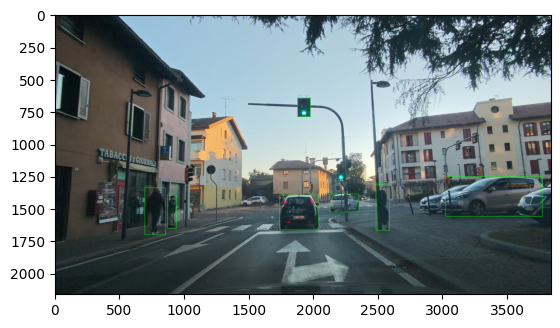

In [12]:
img = cv2.imread("/workspace/videos/distance_calibration.png")
_img = img.copy()

img = Image.fromarray(img)

results = yolo.infer(img)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

for i, d in enumerate(detections.xyxy):
    x_min, y_min, x_max, y_max = d
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    label = detections.data["class_name"][i]

    # Draw the bounding box
    cv2.rectangle(_img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

    # Add the label above the bounding box
    text_position = (x_min, y_min - 10)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    text_color = (0, 255, 0)
    cv2.putText(_img, label, text_position, font, font_scale, text_color, font_thickness)
    
plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))

In [13]:
detections

Detections(xyxy=array([[3018., 1253., 3765., 1560.],
       [ 694., 1340.,  854., 1703.],
       [2480., 1317., 2585., 1671.],
       [1873.,  644., 1974.,  793.],
       [1735., 1396., 2039., 1665.],
       [ 868., 1399.,  938., 1652.],
       [2124., 1388., 2348., 1527.]]), mask=None, confidence=array([0.80901754, 0.74456972, 0.74346602, 0.72579879, 0.68919528,
       0.58197492, 0.55099857]), class_id=array([2, 0, 0, 9, 2, 0, 2]), tracker_id=None, data={'class_name': array(['car', 'person', 'person', 'traffic light', 'car', 'person', 'car'],
      dtype='<U13')}, metadata={})

In [14]:
x1,y1,x2,y2 = detections.xyxy[3]
height = y2 - y1 # px
distance = 5.83 # m
FACTOR = height * distance
def get_distance(height):
    distance = FACTOR/height
    return str(int(distance*100)/100) + " m"

In [15]:
def pipeline2(frame):
    _img = frame.copy()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    results = yolo.infer(img)[0]

    # load the results into the supervision Detections api
    detections = sv.Detections.from_inference(results)

    for i, d in enumerate(detections.xyxy):
        x_min, y_min, x_max, y_max = d
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        label = detections.data["class_name"][i]

        # Draw the bounding box
        cv2.rectangle(_img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Add the label above the bounding box
        text_position = (x_min, y_min - 10)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (0, 255, 0)
        cv2.putText(_img, label, text_position, font, font_scale, text_color, font_thickness)


    for i, d in enumerate(detections.xyxy):
        className = detections.data["class_name"][i]
        if className != "traffic light":
            continue

        cropped = np.array(img)[int(d[1]):int(d[3]), int(d[0]):int(d[2])]

        cropped = Image.fromarray(cropped)
        input_tensor = transform(cropped)
        input_tensor = input_tensor.to(device)
        output = model(input_tensor.reshape(1, *input_tensor.shape))
        j = np.argmax(output.cpu().detach().numpy()[0])

        _color = color[j]

        font = cv2.FONT_HERSHEY_SIMPLEX
        # fontScale
        fontScale = 1
        # Blue color in BGR
        fontColor = (255, 0, 0)
        # Line thickness of 2 px
        thickness = 2

        _img = cv2.putText(_img, _color, (int(d[0]), int(d[1])), font, 
                   fontScale, fontColor, thickness, cv2.LINE_AA)
        
        # now the distance
        height = int(d[3]) - int(d[1])
        _img = cv2.putText(_img, get_distance(height), (int(d[0] + 100), int(d[1])), font, 
                   fontScale, fontColor, thickness, cv2.LINE_AA)
    
    return _img

In [16]:
video_path = "/workspace/videos/my_car.mp4"
video_path_out = "/workspace/videos/out2.mp4"

cap = cv2.VideoCapture(video_path)
writer = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'mp4v'), 24, (3840, 2160))

i = 0
for frame in frame_iter(cap, "Video processing"):
    frame = pipeline2(frame)
    
    writer.write(frame)
    #i += 1
    #if i == 100: break

cap.release()
writer.release()

os.system(f"ffmpeg -y -i {video_path_out} -vcodec libx264 {video_path_out}.mp4")

Video processing: 100%|██████████| 1962/1962 [09:21<00:00,  3.49it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-li

0

In [17]:
Video(f"{video_path_out}.mp4")